In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import json
import wandb

from src.utils import normalize_curve, compute_integral

In [3]:
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim/')

T = 125
net_id = 'gbmooeqh'
all_shortnames = {'_'.join(fp.name.split('_')[:3]) for fp in results_dir.glob(f'{net_id}_*_{T}_*.json')}
all_shortnames.add('baseline_bs_0')
all_shortnames
for shortname in all_shortnames:
    print(shortname)
    print(len(list(results_dir.glob(shortname+f'_{T}_2*.json'))))

baseline_bs_0
60
gbmooeqh_ef_500
3
gbmooeqh_ef_200
60


In [17]:
api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
model_name = run.group[len('Best-'):]
model_name

'Optimals'

In [18]:
def load_all_results(shortname: str):
    results = list()
    for result_fpath in results_dir.glob(shortname+f'_{T}_2*.json'):
        size = int(result_fpath.name.split('_')[-2])
        size_id = int(result_fpath.name.split('_')[-1][:-len('.json')])

        with open(result_fpath) as f:
            result = json.load(f)

        solution_fpath = opts_dir/f"{T}_{size}_{size_id}_opt.npz"
        solution_npz = np.load(solution_fpath)
        quasi_optimal_objective = solution_npz['arr_0'].astype('uint32')

        results.append(dict(
            size=size,
            size_id=size_id,
            opt_obj=quasi_optimal_objective,
            **result
        ))
    df = pd.DataFrame(results)
    df['primal_curve'] = df['primal_curve'].apply(normalize_curve)
    df['primal_curve'] = df['primal_curve'] / df['opt_obj']

    return df

dfs = {shortname.replace(net_id, model_name): load_all_results(shortname) for shortname in all_shortnames}
# dfs['bs_0'] = dfs['bs_0'][dfs['bs_0']['size'] != 9]

In [19]:
d = dfs['baseline_bs_0']
d.groupby('size')['infeasible'].sum() / 20

size
20    0.30
22    0.25
24    0.50
Name: infeasible, dtype: float64

In [20]:
infeasibilities = list()
sns = list()
for sn in dfs.keys():
    df = dfs[sn]
    infeasibility = df['infeasible'].sum() / df.shape[0]

    sns.append(sn)
    infeasibilities.append(infeasibility)

pd.Series(infeasibilities, index=sns, name='infeasibility rate').sort_index()

Optimals_ef_200    0.333333
Optimals_ef_500    0.666667
baseline_bs_0      0.350000
Name: infeasibility rate, dtype: float64

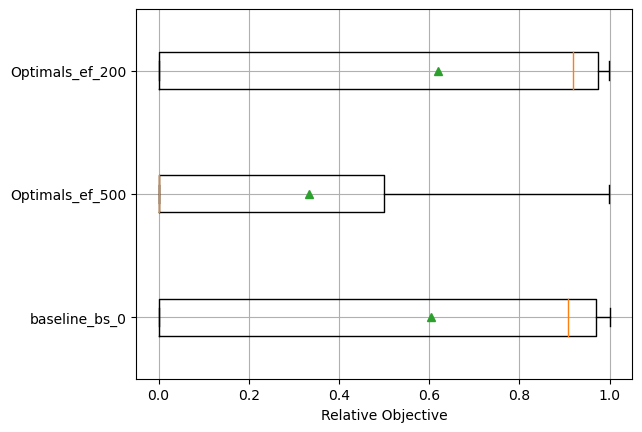

In [21]:
rel_objs = list()
sns = list()
for sn, df in dfs.items():
    rel_objs.append((df['objective'] / df['opt_obj']).values)
    sns.append(sn)
    # (df['objective'] / df['opt_obj']).plot.box(showmeans=True)
plt.boxplot(rel_objs, labels=sns, vert=False, showmeans=True)
# plt.xlim(0.8,1)
plt.xlabel('Relative Objective')
plt.grid()
plt.show()

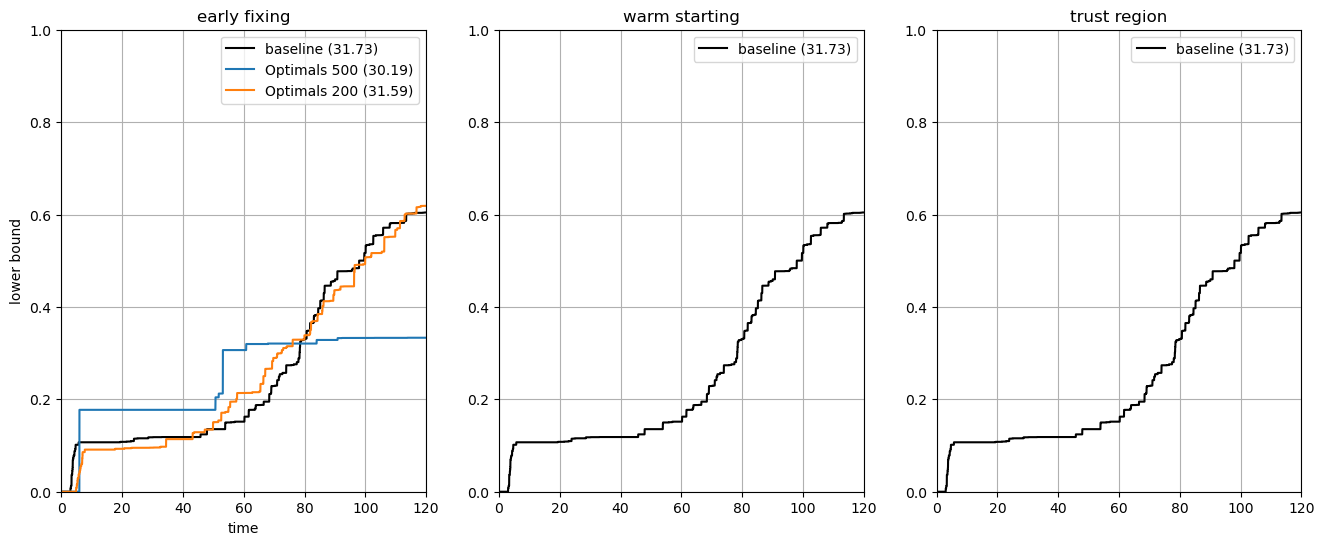

In [25]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

fig, axs = plt.subplots(1,3)

fig.set_size_inches(16,6)

axs[0].set_title('early fixing')
axs[1].set_title('warm starting')
axs[2].set_title('trust region')

for sn, df in dfs.items():
    dt = 1e-3
    curve = df['primal_curve'].mean()
    auc = np.sum(curve * dt)
    x = np.arange(len(curve)) * dt
    if 'ef' in sn:
        ax = axs[0]
    elif 'ws' in sn:
        ax = axs[1]
    elif 'tr' in sn:
        ax = axs[2]
    else:
        for ax in axs:
            ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
        continue
    ax.plot(x, curve, label=sn.split('_')[0]+' '+sn.split('_')[2]+f" ({auc:.2f})")
    ax.set_ylabel('lower bound')
    ax.set_xlabel('time')
# plt.plot(df[~df['infeasible']]['primal_curve'].mean())

for ax in axs:
    ax.set_xlim(0,120)
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid()
plt.show()

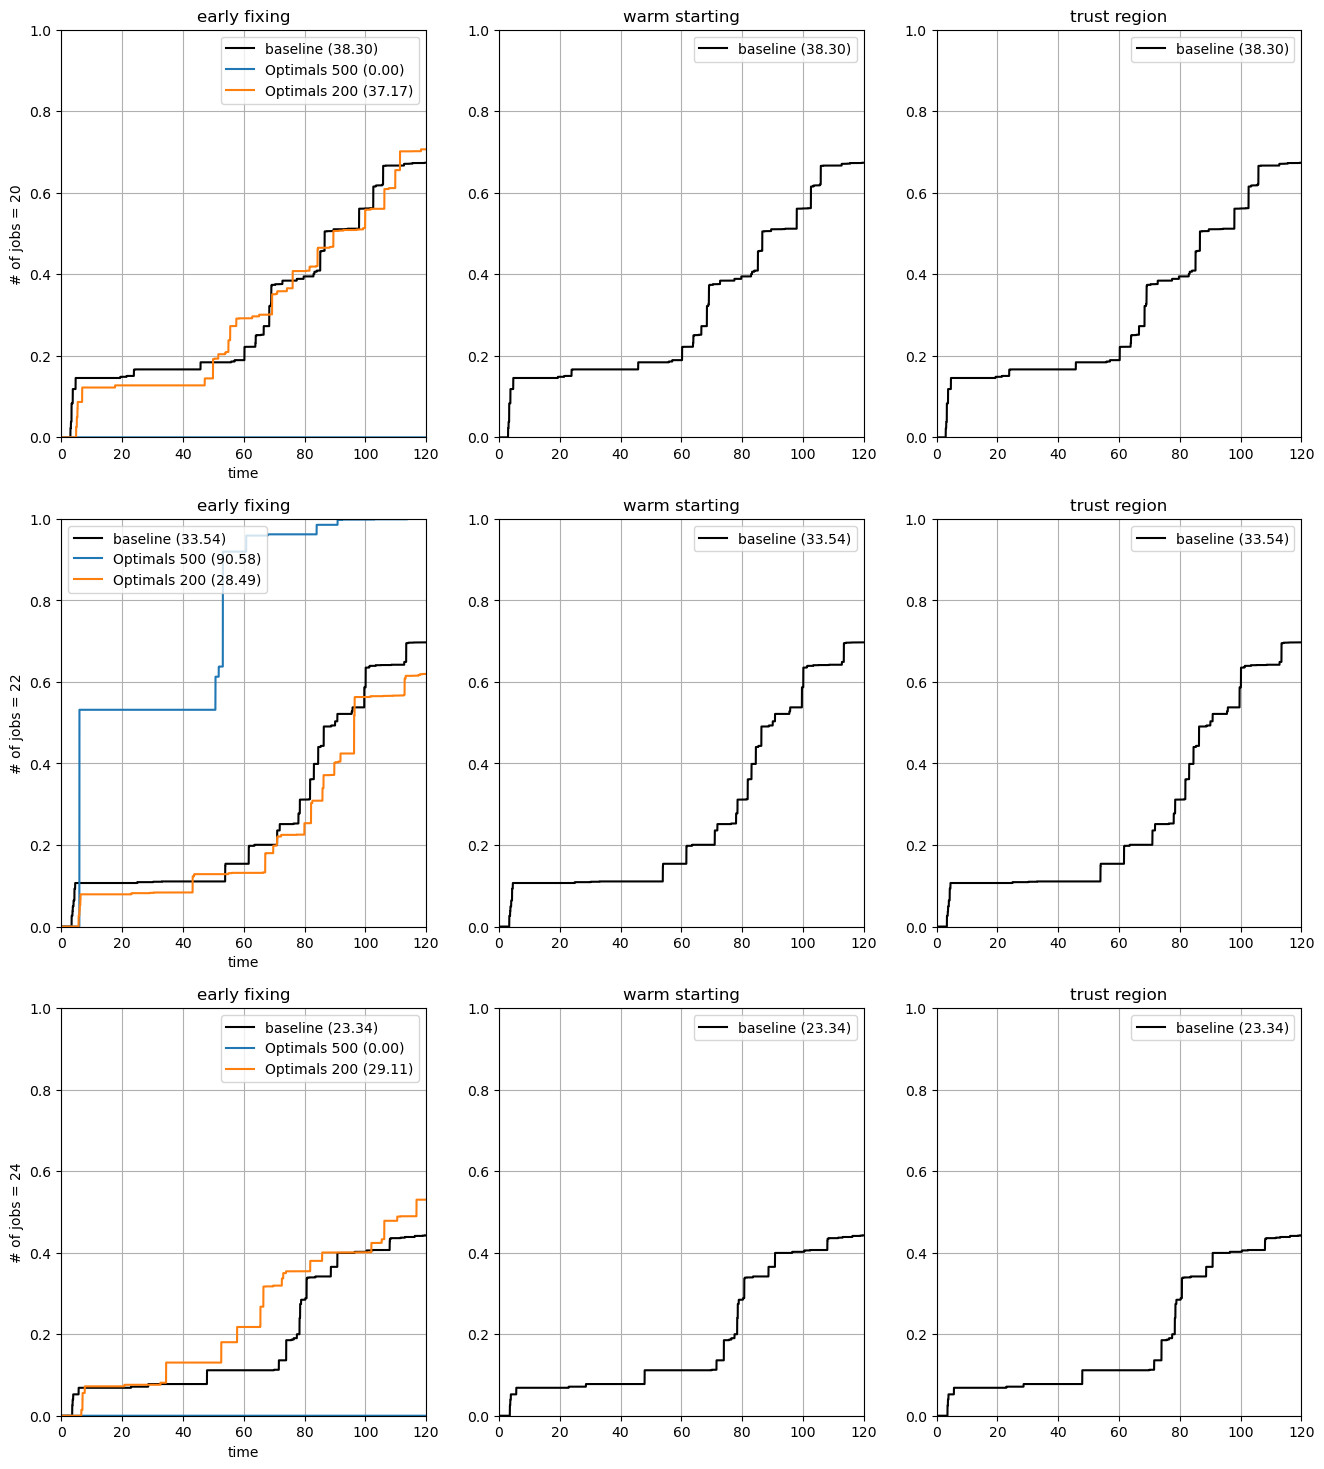

In [27]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

sizes = sorted(dfs['baseline_bs_0']['size'].unique())

fig, axss = plt.subplots(len(sizes),3)

fig.set_size_inches(16,len(sizes) * 6)

for i, s in enumerate(sizes):
    axs = axss[i]

    axs[0].set_title('early fixing')
    axs[1].set_title('warm starting')
    axs[2].set_title('trust region')

    for sn, df_ in dfs.items():
        df = df_[df_['size'] == s]

        dt = 1e-3
        curve = df['primal_curve'].mean()
        auc = np.sum(curve * dt)
        x = np.arange(len(curve)) * dt

        if 'ef' in sn:
            ax = axs[0]
        elif 'ws' in sn:
            ax = axs[1]
        elif 'tr' in sn:
            ax = axs[2]
        else:
            for ax in axs:
                ax.plot(x, curve, color='black', label=f"baseline ({auc:.2f})")
            continue
        # ax.plot(x, curve, label=sn+f" ({auc:.2f})")
        ax.plot(x, curve, label=sn.split('_')[0]+' '+sn.split('_')[2]+f" ({auc:.2f})")
        ax.set_ylabel('lower bound')
        ax.set_xlabel('time')
    # plt.plot(df[~df['infeasible']]['primal_curve'].mean())

    for ax in axs:
        ax.set_xlim(0,120)
        ax.set_ylim(0,1)
        ax.legend()
        ax.grid()

    axs[0].set_ylabel(f'# of jobs = {s}')
plt.show()